In [ ]:
import numpy as np
import random

# Dados dos produtos (Fardo de Latas e Engradado de Garrafas)
produtos = [
    {"id": 1, "nome": "Fardo de Latas", "volume": 0.2, "peso": 30, "valor": 150},
    {"id": 2, "nome": "Engradado de Garrafas", "volume": 0.5, "peso": 20, "valor": 100},
]

# Gerar uma lista de 100 produtos aleatórios
np.random.seed(42)
produtos_amostra = [
    {**random.choice(produtos), "id": i + 1} for i in range(1000)
]

# Dados dos caminhões
caminhoes = [
    {"id": 1, "volume": 20, "peso": 1000, "volume_usado": 0, "peso_usado": 0},
    {"id": 2, "volume": 40, "peso": 2000, "volume_usado": 0, "peso_usado": 0},
    {"id": 3, "volume": 60, "peso": 3000, "volume_usado": 0, "peso_usado": 0},
    {"id": 4, "volume": 80, "peso": 4000, "volume_usado": 0, "peso_usado": 0},
    {"id": 5, "volume": 100, "peso": 5000, "volume_usado": 0, "peso_usado": 0},
    {"id": 6, "volume": 120, "peso": 6000, "volume_usado": 0, "peso_usado": 0},
    {"id": 7, "volume": 140, "peso": 7000, "volume_usado": 0, "peso_usado": 0},
    {"id": 8, "volume": 160, "peso": 8000, "volume_usado": 0, "peso_usado": 0},
    {"id": 9, "volume": 180, "peso": 9000, "volume_usado": 0, "peso_usado": 0},
    {"id": 10, "volume": 200, "peso": 10000, "volume_usado": 0, "peso_usado": 0},
]

# Parâmetros do Algoritmo Genético
POPULATION_SIZE = 200  # Número de soluções na população
GENERATIONS = 5000  # Número de gerações
MUTATION_RATE = 0.1  # Taxa de mutação

# Função de fitness
def fitness(solution):
    valor_total = 0
    penalidade = 0

    # Resetar volume e peso usados antes de calcular a fitness
    for caminhao in caminhoes:
        caminhao["volume_usado"] = 0
        caminhao["peso_usado"] = 0

    for caminhao in caminhoes:
        volume_usado = 0
        peso_usado = 0

        for produto, alocacao in zip(produtos_amostra, solution):
            if alocacao == caminhao["id"]:
                volume_usado += produto["volume"]
                peso_usado += produto["peso"]
                valor_total += produto["valor"]

        # Atualizar volume e peso usados
        caminhao["volume_usado"] += volume_usado
        caminhao["peso_usado"] += peso_usado

        # Penalidades por exceder capacidade
        if volume_usado > caminhao["volume"]:
            penalidade += (volume_usado - caminhao["volume"]) * 20
        if peso_usado > caminhao["peso"]:
            penalidade += (peso_usado - caminhao["peso"]) * 20

    return valor_total - penalidade

# Função para gerar uma solução inicial
def generate_solution():
    return [random.choice([c["id"] for c in caminhoes]) for _ in produtos_amostra]

# Função para criar a população inicial
def initialize_population():
    return [generate_solution() for _ in range(POPULATION_SIZE)]

# Função de seleção por torneio
def selection(population, fitness_scores):
    selected = random.choices(population, weights=fitness_scores, k=2)
    return selected

# Função de cruzamento (crossover)
def crossover(parent1, parent2):
    point = random.randint(0, len(parent1) - 1)
    child = parent1[:point] + parent2[point:]
    return child

# Função de mutação
def mutate(solution):
    if random.random() < MUTATION_RATE:
        index = random.randint(0, len(solution) - 1)
        solution[index] = random.choice([c["id"] for c in caminhoes])

# Algoritmo Genético (Treinamento)
def genetic_algorithm():
    population = initialize_population()

    for generation in range(GENERATIONS):
        # Avaliar a população
        fitness_scores = [fitness(sol) for sol in population]

        # Nova geração
        new_population = []
        for _ in range(POPULATION_SIZE // 2):
            parent1, parent2 = selection(population, fitness_scores)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)

            mutate(child1)
            mutate(child2)

            new_population.extend([child1, child2])

        population = new_population

        # Melhor solução da geração
        best_fitness = max(fitness_scores)
        print(f"Geração {generation + 1}: Melhor Fitness = {best_fitness}")

    # Melhor solução final
    final_fitness_scores = [fitness(sol) for sol in population]
    best_final_solution = population[np.argmax(final_fitness_scores)]

    # Imprimir volume e peso usados por caminhão
    print("\nVolume e Peso Usados por Caminhão:")
    for caminhao in caminhoes:
        print(f"Caminhão {caminhao['id']} - Volume Usado: {caminhao['volume_usado']}m³, Peso Usado: {caminhao['peso_usado']}kg")

    return best_final_solution, max(final_fitness_scores)

# Executar o AG e retornar a melhor solução
best_solution, best_fitness = genetic_algorithm()
print("\nMelhor Solução Encontrada:", best_solution)


Geração 1: Melhor Fitness = 99910.0
Geração 2: Melhor Fitness = 100516.0
Geração 3: Melhor Fitness = 101916.0
Geração 4: Melhor Fitness = 104952.0
Geração 5: Melhor Fitness = 101740.0
Geração 6: Melhor Fitness = 103348.0
Geração 7: Melhor Fitness = 105506.0
Geração 8: Melhor Fitness = 105622.0
Geração 9: Melhor Fitness = 101730.0
Geração 10: Melhor Fitness = 101494.0
Geração 11: Melhor Fitness = 102476.0
Geração 12: Melhor Fitness = 102928.0
Geração 13: Melhor Fitness = 102730.0
Geração 14: Melhor Fitness = 107192.0
Geração 15: Melhor Fitness = 107150.0
Geração 16: Melhor Fitness = 106820.0
Geração 17: Melhor Fitness = 108592.0
Geração 18: Melhor Fitness = 107330.0
Geração 19: Melhor Fitness = 106920.0
Geração 20: Melhor Fitness = 106510.0
Geração 21: Melhor Fitness = 107330.0
Geração 22: Melhor Fitness = 108538.0
Geração 23: Melhor Fitness = 107308.0
Geração 24: Melhor Fitness = 109702.0
Geração 25: Melhor Fitness = 107226.0
Geração 26: Melhor Fitness = 110626.0
Geração 27: Melhor Fit

In [36]:
import matplotlib.pyplot as plt

# Função para visualizar produtos
def visualizar_produtos():
    print("Produtos:")
    for produto in produtos_amostra:
        print(f"ID: {produto['id']}, Nome: {produto['nome']}, Volume: {produto['volume']}m³, Peso: {produto['peso']}kg, Valor: R${produto['valor']}")
    print("\n")

# Função para visualizar a alocação dos produtos
def visualizar_alocacao(solution):
    print("Alocação dos Produtos nos Caminhões:")
    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        print(f"Produto {produto['nome']} (ID {produto['id']}) -> Caminhão {alocado_a_caminhao}")
    print("\n")

# Função para visualizar a carga total por caminhão (com gráfico)
def visualizar_carga_por_caminhao(solution):
    cargas_por_caminhao = {caminhao['id']: {'volume': 0, 'peso': 0, 'valor': 0} for caminhao in caminhoes}

    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        for caminhao in caminhoes:
            if caminhao['id'] == alocado_a_caminhao:
                cargas_por_caminhao[caminhao['id']]['volume'] += produto['volume']
                cargas_por_caminhao[caminhao['id']]['peso'] += produto['peso']
                cargas_por_caminhao[caminhao['id']]['valor'] += produto['valor']

    # carga por caminhão
    volumes = [cargas_por_caminhao[caminhao['id']]['volume'] for caminhao in caminhoes]
    pesos = [cargas_por_caminhao[caminhao['id']]['peso'] for caminhao in caminhoes]
    valores = [cargas_por_caminhao[caminhao['id']]['valor'] for caminhao in caminhoes]
    
    # % carga ocupada
    eficiencia_volume = [vol / caminhao['volume'] * 100 for vol, caminhao in zip(volumes, caminhoes)]
    eficiencia_peso = [peso / caminhao['peso'] * 100 for peso, caminhao in zip(pesos, caminhoes)]

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Gráfico de volume por caminhão
    axs[0, 0].bar([caminhao['id'] for caminhao in caminhoes], volumes, color='blue', alpha=0.7)
    axs[0, 0].set_title('Volume Total por Caminhão')
    axs[0, 0].set_xlabel('ID do Caminhão')
    axs[0, 0].set_ylabel('Volume (m³)')
    
    # Gráfico de peso por caminhão
    axs[0, 1].bar([caminhao['id'] for caminhao in caminhoes], pesos, color='green', alpha=0.7)
    axs[0, 1].set_title('Peso Total por Caminhão')
    axs[0, 1].set_xlabel('ID do Caminhão')
    axs[0, 1].set_ylabel('Peso (kg)')

    # Gráfico de valor por caminhão
    axs[1, 0].bar([caminhao['id'] for caminhao in caminhoes], valores, color='orange', alpha=0.7)
    axs[1, 0].set_title('Valor Total por Caminhão')
    axs[1, 0].set_xlabel('ID do Caminhão')
    axs[1, 0].set_ylabel('Valor (R$)')

    # Eficiência de carga (percentual de volume ocupado)
    axs[1, 1].bar([caminhao['id'] for caminhao in caminhoes], eficiencia_volume, color='purple', alpha=0.7, label="Volume")
    axs[1, 1].bar([caminhao['id'] for caminhao in caminhoes], eficiencia_peso, color='red', alpha=0.7, label="Peso")
    axs[1, 1].set_title('Eficiência de Carga (Volume e Peso Ocupados)')
    axs[1, 1].set_xlabel('ID do Caminhão')
    axs[1, 1].set_ylabel('Eficiência (%)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Função para calcular o valor total das cargas alocadas
def calcular_valor_total(solution):
    valor_total = 0
    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        for caminhao in caminhoes:
            if caminhao['id'] == alocado_a_caminhao:
                valor_total += produto['valor']
    return valor_total



Produtos:
ID: 1, Nome: Fardo de Latas, Volume: 0.2m³, Peso: 30kg, Valor: R$150
ID: 2, Nome: Fardo de Latas, Volume: 0.2m³, Peso: 30kg, Valor: R$150
ID: 3, Nome: Fardo de Latas, Volume: 0.2m³, Peso: 30kg, Valor: R$150
ID: 4, Nome: Fardo de Latas, Volume: 0.2m³, Peso: 30kg, Valor: R$150
ID: 5, Nome: Fardo de Latas, Volume: 0.2m³, Peso: 30kg, Valor: R$150
ID: 6, Nome: Fardo de Latas, Volume: 0.2m³, Peso: 30kg, Valor: R$150
ID: 7, Nome: Engradado de Garrafas, Volume: 0.5m³, Peso: 20kg, Valor: R$100
ID: 8, Nome: Fardo de Latas, Volume: 0.2m³, Peso: 30kg, Valor: R$150
ID: 9, Nome: Fardo de Latas, Volume: 0.2m³, Peso: 30kg, Valor: R$150
ID: 10, Nome: Engradado de Garrafas, Volume: 0.5m³, Peso: 20kg, Valor: R$100
ID: 11, Nome: Engradado de Garrafas, Volume: 0.5m³, Peso: 20kg, Valor: R$100
ID: 12, Nome: Fardo de Latas, Volume: 0.2m³, Peso: 30kg, Valor: R$150
ID: 13, Nome: Engradado de Garrafas, Volume: 0.5m³, Peso: 20kg, Valor: R$100
ID: 14, Nome: Engradado de Garrafas, Volume: 0.5m³, Peso: 20k

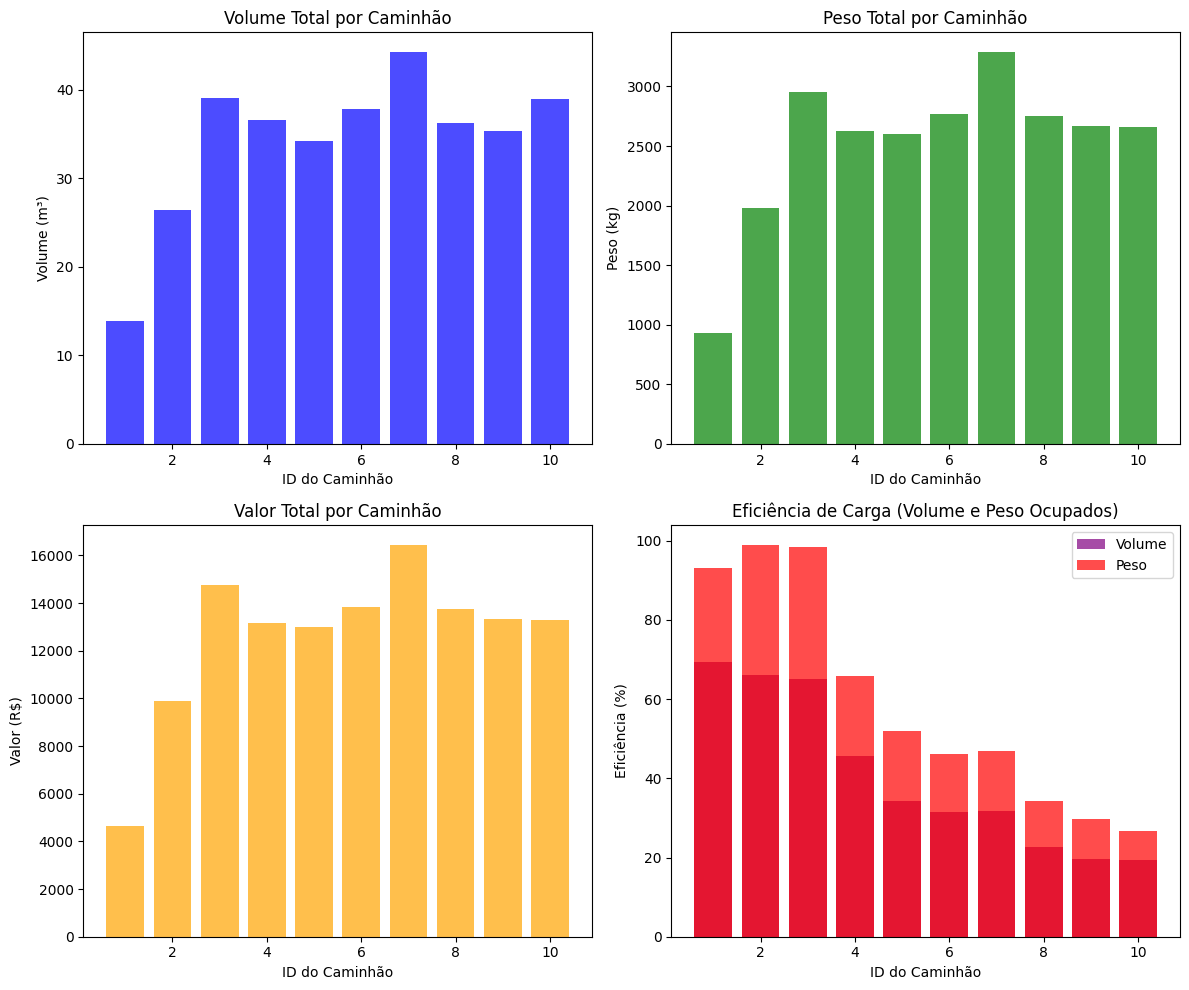

Valor Total das Cargas Alocadas: R$126150


In [37]:
visualizar_produtos()
visualizar_alocacao(best_solution)
visualizar_carga_por_caminhao(best_solution)
valor_total = calcular_valor_total(best_solution)
print(f"Valor Total das Cargas Alocadas: R${valor_total}")


In [38]:

def visualizar_carga_por_caminhao(solution):
    cargas_por_caminhao = {caminhao['id']: {'volume': 0, 'peso': 0, 'valor': 0} for caminhao in caminhoes}

    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        for caminhao in caminhoes:
            if caminhao['id'] == alocado_a_caminhao:
                cargas_por_caminhao[caminhao['id']]['volume'] += produto['volume']
                cargas_por_caminhao[caminhao['id']]['peso'] += produto['peso']
                cargas_por_caminhao[caminhao['id']]['valor'] += produto['valor']

    print("Cargas por Caminhão:")
    for caminhao in caminhoes:
        carga = cargas_por_caminhao[caminhao['id']]
        print(f"Caminhão {caminhao['id']} - Volume Total: {carga['volume']}m³, Peso Total: {carga['peso']}kg, Valor Total: R${carga['valor']}")
    print("\n")

visualizar_carga_por_caminhao(best_solution)

Cargas por Caminhão:
Caminhão 1 - Volume Total: 13.899999999999995m³, Peso Total: 930kg, Valor Total: R$4650
Caminhão 2 - Volume Total: 26.39999999999998m³, Peso Total: 1980kg, Valor Total: R$9900
Caminhão 3 - Volume Total: 39.100000000000016m³, Peso Total: 2950kg, Valor Total: R$14750
Caminhão 4 - Volume Total: 36.59999999999999m³, Peso Total: 2630kg, Valor Total: R$13150
Caminhão 5 - Volume Total: 34.19999999999999m³, Peso Total: 2600kg, Valor Total: R$13000
Caminhão 6 - Volume Total: 37.900000000000006m³, Peso Total: 2770kg, Valor Total: R$13850
Caminhão 7 - Volume Total: 44.30000000000004m³, Peso Total: 3290kg, Valor Total: R$16450
Caminhão 8 - Volume Total: 36.30000000000001m³, Peso Total: 2750kg, Valor Total: R$13750
Caminhão 9 - Volume Total: 35.39999999999999m³, Peso Total: 2670kg, Valor Total: R$13350
Caminhão 10 - Volume Total: 39.000000000000014m³, Peso Total: 2660kg, Valor Total: R$13300




In [ ]:
# Calcular eficiência por caminhão

In [44]:
# Mapear sobras